### Machine Learning for Asset Managers

#Chapter 2: Denoising and Detoning

Esse segundo capítulo apresenta uma metodologia parar tratar o ruído e reter o sinal de matrizes de covariância. Esse procedimento é muito útil para obter melhores carteiras com o processo de Markovitz. Para isso, usamos da conclusão do  teorema de Marchenko-Pastur, que diz que uma matriz (NxT) com entradas iid cujo processo gerador dos dados possui média zero e variância definida terá, quando N, T tenderem ao infinito, autovalores que seguirão um dada distribuiço — Marchenko-Pastur.


Tentei juntar a explicação de vários lugares. Os códgios não são necessariamente meus.
Além do livro, utilizei essa fonte: https://medium.com/swlh/an-empirical-view-of-marchenko-pastur-theorem-1f564af5603d

In [13]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

In [8]:
def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf


In [11]:
def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [54]:
def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

Acima temos as funções que usaremos. A primeira é a função de distribuição de probabilidades de Marchenko-Pastur, a segunda calcula os autovalores e autovetores de uma matriz e por fim a terceira ajusta uma função de densidade Kernel a matriz. O próximo passo é gerar uma matriz aleatória e testar o teorema.  

In [53]:
#Gerando uma matriz aleatoria 
np.random.seed(123)
x = np.random.normal(size=(10000,1000))
x


array([[-1.0856306 ,  0.99734545,  0.2829785 , ..., -0.90932702,
         0.47026375, -1.11143045],
       [-0.74882747,  0.56759473,  0.71815054, ..., -0.35929672,
        -1.60969508,  0.01357006],
       [-1.77422355, -1.20137731,  1.09625679, ...,  2.04043199,
         1.01591697, -1.63378817],
       ...,
       [ 0.74653161,  0.90786531, -0.75260661, ..., -0.57423796,
        -0.97992589,  0.47526078],
       [ 2.6618881 ,  1.44373246, -1.64705105, ..., -1.24904441,
         1.16491629,  1.61043992],
       [-1.22281157,  0.13877042,  0.60484863, ..., -0.52814446,
         0.08482555,  0.9228148 ]])

In [41]:
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

In [42]:
eVal0 #Autovalores


array([[1.72345366, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.72271149, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.70937094, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.47714642, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.47645736,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.46543484]])

In [43]:
eVec0 #Autovetores

array([[ 0.0002629 , -0.041895  ,  0.0234236 , ...,  0.03926407,
        -0.03878253,  0.01982549],
       [-0.00446892, -0.01403512, -0.01877192, ..., -0.00511263,
        -0.02679496,  0.03269802],
       [-0.01348884, -0.00816666, -0.02087269, ..., -0.01520895,
         0.05970443, -0.03581736],
       ...,
       [-0.03044996, -0.03794991,  0.05491049, ..., -0.0319976 ,
        -0.04647435,  0.03270032],
       [-0.06155423, -0.0123507 , -0.00510323, ..., -0.00608499,
        -0.00309777, -0.03927227],
       [ 0.05215356,  0.05695049, -0.06556502, ..., -0.01099847,
         0.00231055, -0.01096587]])

In [44]:
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
pdf0

0.467544    0.000000
0.468811    0.135795
0.470077    0.191429
0.471343    0.233705
0.472609    0.269001
              ...   
1.727391    0.073598
1.728657    0.063723
1.729923    0.052018
1.731189    0.036774
1.732456    0.000000
Length: 1000, dtype: float64

In [45]:
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)
pdf1

0.465435    0.120657
0.476457    0.303028
0.477146    0.316537
0.481516    0.401404
0.482399    0.417799
              ...   
1.698020    0.180942
1.706167    0.160699
1.709371    0.151060
1.722711    0.109031
1.723454    0.105742
Length: 1000, dtype: float64

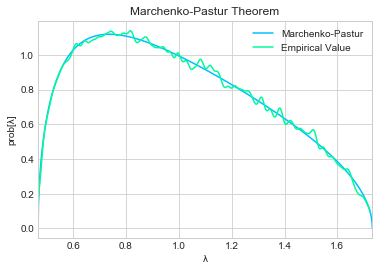

In [46]:
# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

In [102]:
def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
        nCols (int): number of columns of random normal. This will be the dimensions of
            the output
        nFacts (int): number of rows of random normal
    Returns:
        np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov

In [103]:
def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
        cov (np.ndarray): covariance matrix
    Returns:
        np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr

In [104]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
        var (float): Variance
        eVal (np.ndarray): Eigenvalues to fit.
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
        pts (int): Number of points used to construct the PDF
    Returns:
        float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse

In [105]:
def findMaxEval(eVal, q, bWidth):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e) everything else larger than
        this, is a signal eigenvalue
    Args:
        eVal (np.ndarray): Eigenvalues to fit on errPDFs
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
    Returns:
         (tuple): tuple containing:
            float: Maximum random eigenvalue
            float: Variance attributed to noise (1-result) is one way to measure
                signal-to-noise
    """

    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var

In [106]:
alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal
# Converting Covariancce to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = getPCA(corr0)

In [94]:
# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [107]:
# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)  # Empirical PDF

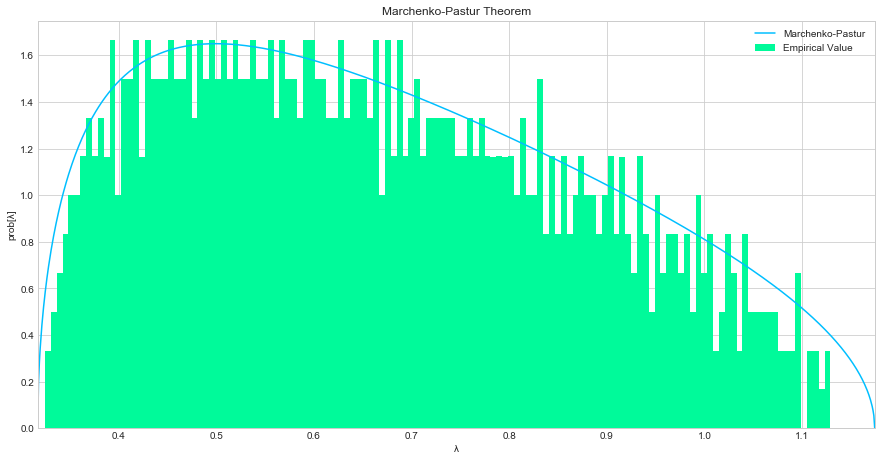

In [108]:
# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(15,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")
#Isso aqui ta erradissimo